<a href="https://colab.research.google.com/github/Hamza-Ali0237/PyTorch-GAN-Implementation/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing GAN from scratch in PyTorch

Dataset: [https://www.kaggle.com/datasets/kvpratama/pokemon-images-dataset](https://www.kaggle.com/datasets/kvpratama/pokemon-images-dataset)

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 20.0 MB/s eta 0:00:00


In [2]:
!pip install torch-fidelity

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch as t
import numpy as np
import torch.nn as nn
import torchvision as tv
import torchmetrics as tm
import matplotlib.pyplot as plt

In [5]:
# Deep Convolutional Generator Block
def dc_gen_block(in_dim, out_dim, kernel_size, stride):
  return nn.Sequential(
      nn.ConvTranspose2d(in_dim, out_dim, kernel_size, stride=stride),
      nn.BatchNorm2d(out_dim),
      nn.ReLU()
  )

# Generator Loss Function
def gen_loss(gen, disc, batch_size, z_dim):
    noise = t.randn(batch_size, z_dim, 1, 1, device=next(gen.parameters()).device)
    fake = gen(noise)
    disc_pred = disc(fake)
    criterion = nn.BCEWithLogitsLoss()
    return criterion(disc_pred, t.ones_like(disc_pred))

# Deep Convolutional Generator Class
class DCGenerator(nn.Module):
    def __init__(self, z_dim, kernel_size=4, stride=2):
        super(DCGenerator, self).__init__()
        self.gen = nn.Sequential(
            dc_gen_block(z_dim, 256, kernel_size, stride),
            dc_gen_block(256, 128, kernel_size, stride),
            dc_gen_block(128, 64, kernel_size, stride),
            nn.ConvTranspose2d(64, 3, kernel_size, stride=stride, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(len(x), -1, 1, 1)
        return self.gen(x)

In [6]:
# Deep Convolutional Discriminator Block
def dc_disc_block(in_dim, out_dim, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=1),
        nn.BatchNorm2d(out_dim),
        nn.LeakyReLU(0.2)
    )

# Discriminator Loss Function

def disc_loss(gen, disc, real, batch_size, z_dim):
    noise = t.randn(batch_size, z_dim, 1, 1, device=next(gen.parameters()).device)
    fake = gen(noise).detach()
    fake_pred = disc(fake)
    real_pred = disc(real)
    criterion = nn.BCEWithLogitsLoss()
    fake_loss = criterion(fake_pred, t.zeros_like(fake_pred) + 0.1)
    real_loss = criterion(real_pred, t.ones_like(real_pred)* 0.9 )
    return (fake_loss + real_loss) / 2

# Deep Convolutional Discriminator Class
class DCDiscriminator(nn.Module):
    def __init__(self, kernel_size=4, stride=2):
        super(DCDiscriminator, self).__init__()
        self.disc = nn.Sequential(
            dc_disc_block(3, 64, kernel_size, stride),
            dc_disc_block(64, 128, kernel_size, stride),
            dc_disc_block(128, 256, kernel_size, stride),
            nn.Conv2d(256, 1, kernel_size, stride=stride, padding=0)
        )

    def forward(self, x):
        return self.disc(x).view(len(x), -1)

# Loading Dataset

In [7]:
# Define Transformations
transform = tv.transforms.Compose([
    tv.transforms.Resize(64),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = tv.datasets.ImageFolder(root="/content/drive/MyDrive/pokemon-dataset/", transform=transform)

dataloader_train = t.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

# Training Model

In [8]:
# HYPERPARAMETERS
z_dim = 128
lr = 0.0001
batch_size = 64
EPOCHS = 10

In [9]:
# Check for GPU availability
device = t.device("cuda" if t.cuda.is_available() else "cpu")

# Models
gen = DCGenerator(z_dim).to(device)
disc = DCDiscriminator().to(device)

# Optimizers
gen_opt = t.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
disc_opt = t.optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

In [10]:
# Training Loop
for epoch in range(EPOCHS):
  for real, _ in dataloader_train:
    real = real.to(device)
    cur_batch_size = len(real)

    # Update Discriminator
    disc_opt.zero_grad()
    d_loss = disc_loss(gen, disc, real, cur_batch_size, z_dim)
    d_loss.backward()
    disc_opt.step()


    # Update Generator
    gen_opt.zero_grad()
    g_loss = gen_loss(gen, disc, cur_batch_size, z_dim)
    g_loss.backward()
    gen_opt.step()

  print(f"Epoch {epoch+1}/{EPOCHS} | Disc Loss: {d_loss.item():.4f} | Gen Loss: {g_loss.item():.4f}")

Epoch 1/10 | Disc Loss: 0.5186 | Gen Loss: 1.3811
Epoch 2/10 | Disc Loss: 0.4613 | Gen Loss: 1.8111
Epoch 3/10 | Disc Loss: 0.4194 | Gen Loss: 2.3079
Epoch 4/10 | Disc Loss: 0.3753 | Gen Loss: 2.6142
Epoch 5/10 | Disc Loss: 0.3485 | Gen Loss: 2.7413
Epoch 6/10 | Disc Loss: 0.3556 | Gen Loss: 3.0730
Epoch 7/10 | Disc Loss: 0.3435 | Gen Loss: 2.8566
Epoch 8/10 | Disc Loss: 0.3438 | Gen Loss: 2.8986
Epoch 9/10 | Disc Loss: 0.3387 | Gen Loss: 2.7561
Epoch 10/10 | Disc Loss: 0.3390 | Gen Loss: 2.8028


# Generating Images

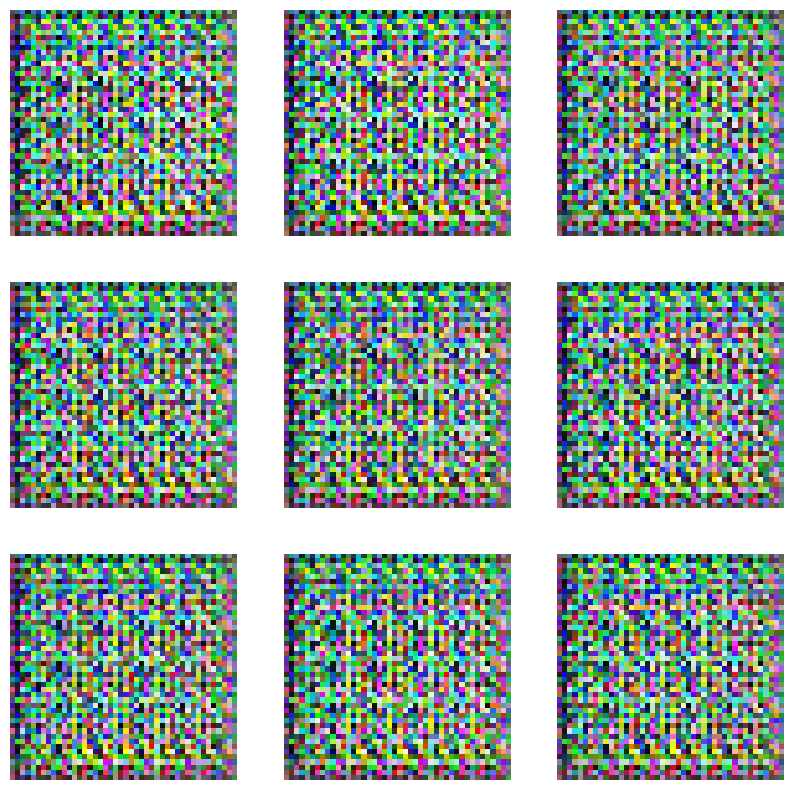

In [11]:
num_images = 9
noise = t.randn(num_images, z_dim, 1, 1).to(next(gen.parameters()).device)

with t.no_grad():
  fake = gen(noise)

plt.figure(figsize=(10, 10))
for i in range(num_images):
    image_tensor = fake[i]
    image_permuted = image_tensor.permute(1, 2, 0).cpu()
    image_denormalized = (image_permuted + 1) / 2

    plt.subplot(3, 3, i + 1)
    plt.imshow(image_denormalized.numpy())
    plt.axis("off")

plt.show()

# Evaluate Model: Frechet Inception Distance

In [12]:
# Initialize FID metric
fid = tm.image.fid.FrechetInceptionDistance(feature=2048).to(device)

real_images, _ = next(iter(dataloader_train))
real_images = real_images.to(device)

num_images = real_images.size(0)
noise = t.randn(num_images, z_dim, 1, 1).to(device)

with t.no_grad():
    fake_images = gen(noise)

# Resize and normalize images
resize_transform = tv.transforms.Resize((299, 299))

real_images_rescaled = []
fake_images_rescaled = []

# Process real images
for img in real_images:
    img = (img + 1) / 2  # Rescale to [0, 1]
    img = tv.transforms.ToPILImage()(img.cpu())
    img = resize_transform(img)
    img = t.tensor(np.array(img), dtype=t.uint8).permute(2, 0, 1)
    real_images_rescaled.append(img)

# Process fake images
for img in fake_images:
    img = (img + 1) / 2
    img = tv.transforms.ToPILImage()(img.cpu())
    img = resize_transform(img)
    img = t.tensor(np.array(img), dtype=t.uint8).permute(2, 0, 1)
    fake_images_rescaled.append(img)

# Convert lists to tensors
real_images_rescaled = t.stack(real_images_rescaled).to(device)
fake_images_rescaled = t.stack(fake_images_rescaled).to(device)

fid.update(real_images_rescaled, real=True)
fid.update(fake_images_rescaled, real=False)

fid_score = fid.compute()
print(f"FID Score: {fid_score.item()}")

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 336MB/s]


FID Score: 428.252197265625
